**INTRODUCTION**

My Capstone 3 project aim to predicting RNA 3D structures using Graph Neural Networks (GNNs). By integrating sequence data, secondary structure information, and base-pairing probabilities, the goal here is to model the spatial configurations of RNA molecules and predict the 3D coordinates of any RNA structures.

RNA (ribonucleic acid) plays a central role in gene expression, regulation, and catalysis. Unlike DNA, which primarily serves as a stable genetic blueprint, RNA molecules are functionally diverse and dynamic. They can carry genetic information (as in mRNA), assist in protein synthesis (tRNA and rRNA), or regulate gene expression and catalyze biochemical reactions (non-coding RNAs like miRNA and ribozymes). Structurally, RNA is typically single-stranded but folds into complex three-dimensional shapes driven by intramolecular base pairing. These structures—formed through stems, loops, bulges, and junctions—are crucial for RNA's biological function and are stabilized by hydrogen bonds, base stacking, and tertiary interactions. Notably, RNA structure plays a key role in CRISPR-based genome editing, where the precise folding of guide RNA is essential for targeting and binding to specific DNA sequences.

Despite its significant role in life’s most essential processes, predicting its 3D structure is still difficult. Deep learning breakthroughs like AlphaFold have transformed protein structure prediction, but progress with RNA has been much slower due to limited data and evaluation methods.

The objective here is to design a machine learning model that predicts the 3D structure of an RNA molecule directly from its primary sequence. This sequence—composed of a linear arrangement of nucleotides (A, U, C, G) connected by phosphodiester bonds and read from the 5′ to 3′ end—serves as the starting point for structural inference. RNA molecules can range in length from as few as 20 nucleotides (e.g., microRNAs) to over 10,000 nucleotides (e.g., viral genomes and long non-coding RNAs), making generalization across sizes a key challenge. The model will be trained to output the three-dimensional spatial coordinates (x, y, z) for each nucleotide in the sequence. This requires a multi-step pipeline including feature extraction from the sequence, optional secondary structure estimation, embedding or vectorization of nucleotide information, and a predictive architecture capable of learning spatial relationships between residues.

**Summary of Workflow Steps**

1. Data Loading and Preprocessing

   - Load datasets containing RNA sequences, secondary structures, and base-pairing probability matrices (BPPMs).

   - Ensure consistency in sequence lengths and handle any discrepancies or missing values.

2. Feature Extraction

   - Generate target feature from label csv file

   - Compute k-mer frequencies to capture local sequence patterns.

   - Extract thermodynamic features such as minimum free energy (MFE).

   - Process BPPMs to represent base-pairing interactions effectively.
   
3. Graph Construction, model building and model Training

   - Define nodes corresponding to nucleotides, enriched with extracted features.

   - Establish edges based on sequential adjacency and significant base-pairing probabilities.

   - Define loss function as Distance Loss that compares pairwise distances between residues in the predicted vs. true structures to enforces global shape and pairwise relationships, not just pointwise accuracy.

   - Assemble the graph data structures for each RNA sequence.

   - Implement a GNN model using frameworks like PyTorch Geometric.

   - Configure layers, activation functions, and other architectural components.

   

   - Train the model over multiple epochs, monitoring performance metrics such as loss and TM-score.

4. Evaluation and Visualization

   - Compare predicted RNA structures against ground truth using metrics like TM-score.

   - Visualize 3D structures to qualitatively assess prediction accuracy.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import RNA

In [5]:
#Load all the dataset available on https://www.kaggle.com/competitions/stanford-rna-3d-folding.

#The test csv gives sequences with unknown coordinates for the final evaluation of the model
#submission csv has to be submitted to the competition page with the predicted coordinates for the RNA molecules listed in the test_sequences.csv
df_test_seq = pd.read_csv('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/test_sequences.csv')
df_submission = pd.read_csv('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/sample_submission.csv')

#Training dataset where train_labels.csv has the coordinates and train_sequences has the sequence and other information about the molecules
df_train_label = pd.read_csv('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/train_labels.v2.csv')
df_train_seq = pd.read_csv('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/train_sequences.v2.csv')

#validation dataset for final model evaluation. The RNA molecules are widely used test set in the RNA modeling field
df_validation_label = pd.read_csv('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/validation_labels.csv')
df_validation_seq = pd.read_csv('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/validation_sequences.csv')



1. Data Loading, exploration and preprocessing of the training dataset

In [6]:
#dataframe the coordinates for each residues within each molecules of the training set
df_train_label.head()

,ID,resname,resid,x_1,y_1,z_1
0,7TAX_M_1,C,1,187.126007,148.246002,210.417999
1,7TAX_M_2,U,2,185.255997,152.968002,204.617996
2,7TAX_M_3,A,3,189.360992,161.802002,205.214996
3,7TAX_M_4,A,4,186.000000,156.595993,209.951996
4,7TAX_M_5,G,5,181.947998,158.186996,213.610992


In [7]:
# Dataframe of the training dataset with more than 800 RNA molecules 
df_train_seq.head()

#Information:
# - Target ID
# - primary sequence
# - temporal cutoff
# - Functionnal description of the RNA molecules 
# - cutofftime is the date in yyyy-mm-dd format that the sequence was published.
# - all sequence all molecular chains present in the experimentally solved structure. In a few cases this may include multiple copies of the target RNA (look for the word "Chains" in the header) and/or partners like other RNAs or proteins or DNA.

,target_id,sequence,temporal_cutoff,description,all_sequences
0,7TAX_M,CUAAGAAAUUCACGGCGGGCUUGAUGUCCGCGUCUACCUGAUUCAC...,2022-09-21,Cryo-EM structure of the Csy-AcrIF24-promoter ...,>7TAX_1|Chain A|CRISPR-associated protein Csy1...
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN..."
2,8PVA_b,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,2023-11-29,Structure of bacterial ribosome determined by ...,>8PVA_1|Chain A|16S rRNA|Escherichia coli (562...
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...


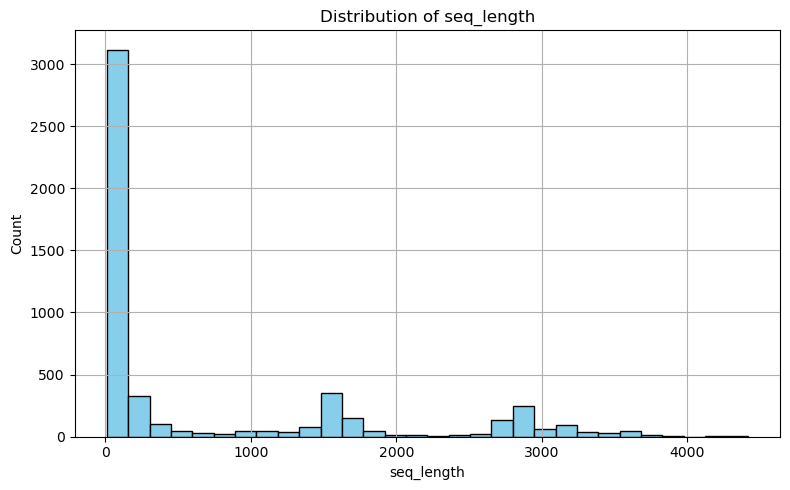

In [8]:
#Looking at the distribution of the size of the sequences in the train set 
df_train_seq['seq_length'] = df_train_seq['sequence'].apply(len)

# Plot histogram
def distribution(column, df):
    plt.figure(figsize=(8, 5))
    plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

distribution('seq_length', df_train_seq)

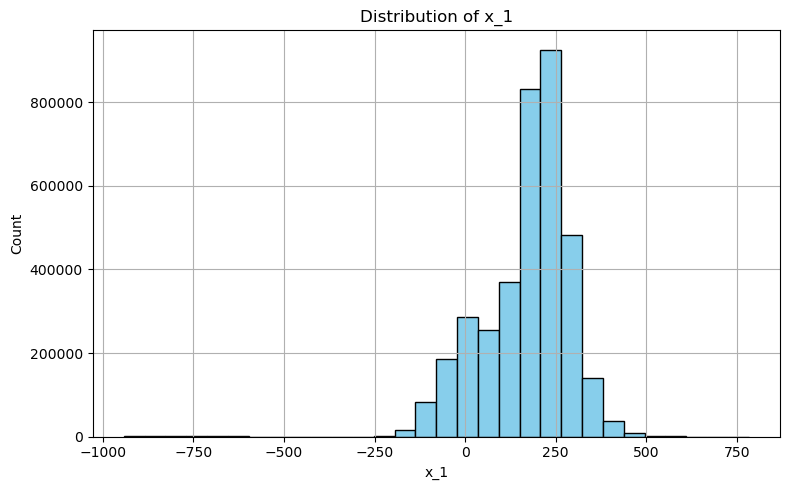

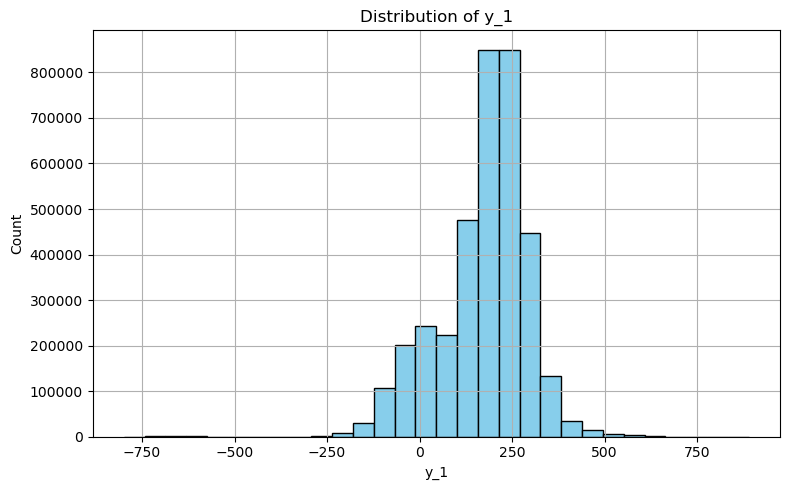

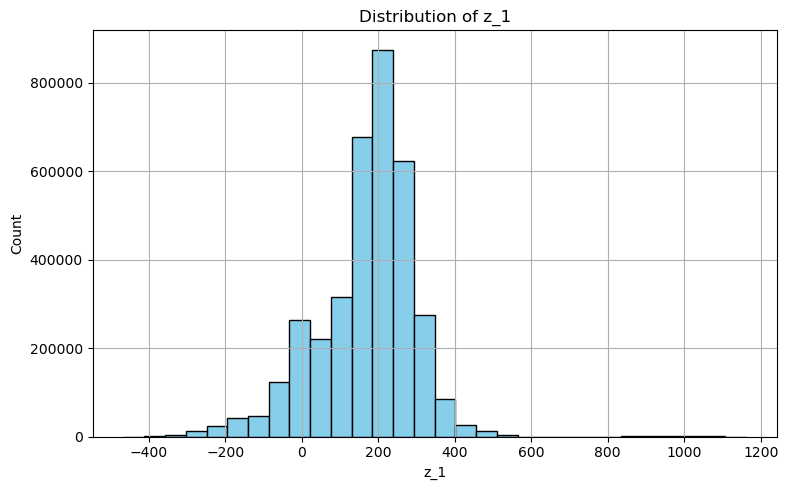

In [9]:

# Distribution of the coordinates values in the labels csv 
columns = ['x_1', 'y_1', 'z_1']
for col in columns:
    distribution(col, df_train_label)

In [10]:
#Standardization of the coordinates
for col in columns:
    mean = df_train_label[col].mean()
    std = df_train_label[col].std()
    df_train_label[f'{col}_std'] = (df_train_label[col] - mean) / (std + 1e-8)
df_train_label.head()

,ID,resname,resid,x_1,y_1,z_1,x_1_std,y_1_std,z_1_std
0,7TAX_M_1,C,1,187.126007,148.246002,210.417999,0.147092,-0.193924,0.331723
1,7TAX_M_2,U,2,185.255997,152.968002,204.617996,0.131939,-0.155188,0.285957
2,7TAX_M_3,A,3,189.360992,161.802002,205.214996,0.165203,-0.082722,0.290668
3,7TAX_M_4,A,4,186.000000,156.595993,209.951996,0.137967,-0.125428,0.328046
4,7TAX_M_5,G,5,181.947998,158.186996,213.610992,0.105133,-0.112376,0.356918


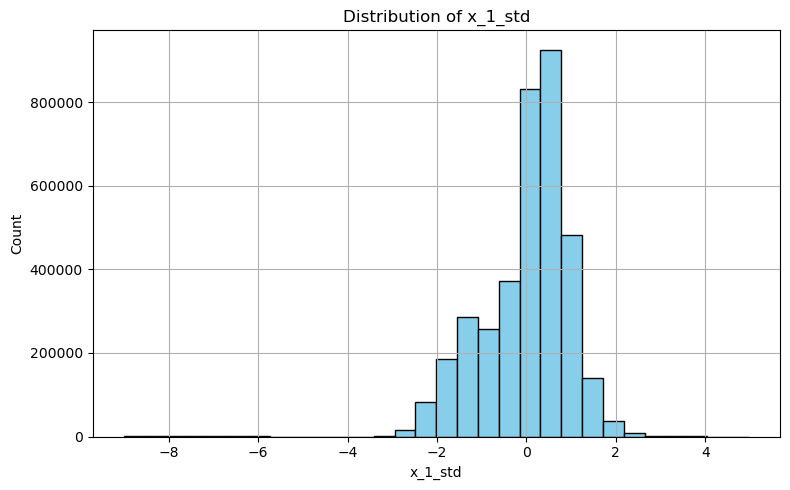

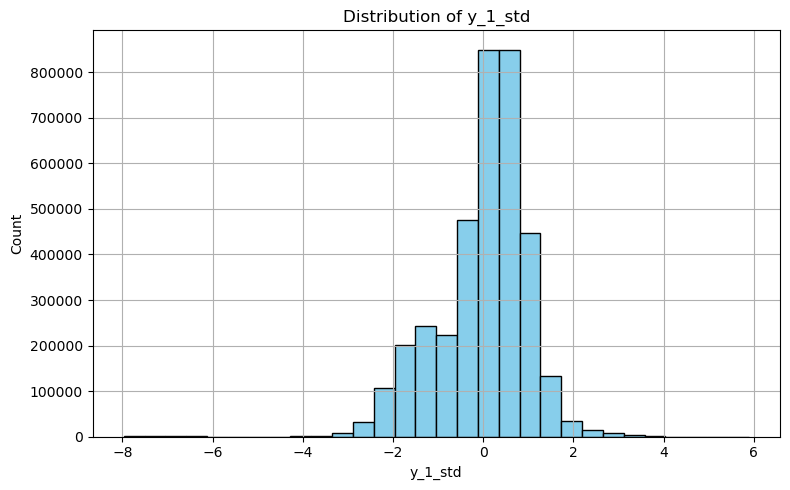

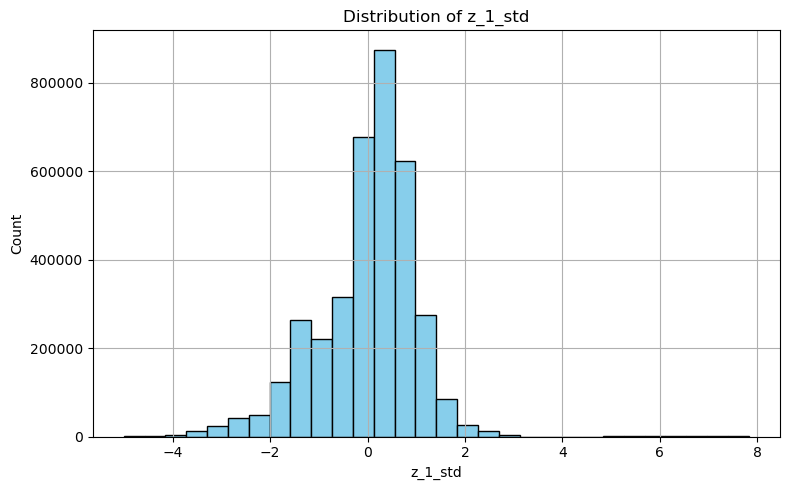

In [11]:
columns = ['x_1_std', 'y_1_std', 'z_1_std']
for col in columns:
    distribution(col, df_train_label)

In [12]:
##confirming length of the sequences  train_sequence.csv is the same than in the train_label.csv file
#generate a separate name culumn in order to group by name 
df_train_label[['name', 'position']] = df_train_label['ID'].str.rsplit('_', n = 1, expand=True)
#Count numbers of residues for each molecule in the train_label.csv
name_counts = df_train_label['name'].value_counts()

In [13]:
#confirming length of the sequences  train_sequence.csv is the same than in the train_label.csv file
df_train_seq['label_length'] = df_train_seq['target_id'].map(name_counts)
df_train_seq['length_match'] = df_train_seq['seq_length'] == df_train_seq['label_length']
print("✅ Matches:", df_train_seq['length_match'].sum())
print("❌ Mismatches:", (~df_train_seq['length_match']).sum())

✅ Matches: 5135
❌ Mismatches: 0


**length of the RNA molecules in the training coordinates label csv file matches the length of the RNA molecules in the training sequence file**

We will only use the primary sequences in order to extract features and the coordinates as target feature to predict.

2- Feature Extraction

In [17]:
#from Bio import SeqIO

In [12]:
#function to read fasta files for later usage
# def read_fasta(file_path):
#     ids = []
#     seqs = []
#     with open(file_path, 'r') as f:
#         seq = ""
#         for line in f:
#             line = line.strip()
#             if line.startswith(">"):
#                 if seq:
#                     seqs.append(seq)
#                     seq = ""
#                 ids.append(line[1:])  # remove '>'
#             else:
#                 seq += line
#         seqs.append(seq)  # add last sequence
#     return pd.DataFrame({'id': ids, 'sequence': seqs})

a- One-hot encoding the primary sequence

In [14]:
def one_hot_rna(seq):
    map_nt = {'A': [1, 0, 0, 0],
              'U': [0, 1, 0, 0],
              'G': [0, 0, 1, 0],
              'C': [0, 0, 0, 1]}
    return np.array([map_nt.get(nt, [0, 0, 0, 0]) for nt in seq])

In [15]:
# One-hot encode sequences
df_train_seq['prim_seq'] = df_train_seq['sequence'].apply(one_hot_rna)


In [16]:
df_train_seq.head()

,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length,label_length,length_match,prim_seq
0,7TAX_M,CUAAGAAAUUCACGGCGGGCUUGAUGUCCGCGUCUACCUGAUUCAC...,2022-09-21,Cryo-EM structure of the Csy-AcrIF24-promoter ...,>7TAX_1|Chain A|CRISPR-associated protein Csy1...,61,61,True,"[[0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [1,..."
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN...",1539,1539,True,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,..."
2,8PVA_b,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,2023-11-29,Structure of bacterial ribosome determined by ...,>8PVA_1|Chain A|16S rRNA|Escherichia coli (562...,120,120,True,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,..."
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...,1056,1056,True,"[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,..."
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...,1554,1554,True,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,..."


b- Create an array of coordinates for each RNA molecule as target feature
 -->format: [[x1, y1, z1], [x2, y2, z2]....[xn, yn, zn]]

In [17]:
# Sort residues by molecule and position
df_train_label = df_train_label.sort_values(['name', 'position'])

# Group by molecule and convert coordinates to array
target_coords = (
    df_train_label.groupby('name')[['x_1', 'y_1', 'z_1']]
    .apply(lambda g: g.to_numpy())
    .reset_index(name='target_coordinates')
)
target_coords.head()

,name,target_coordinates
0,17RA_A,"[[35.85699844360352, -10.769000053405762, -7.5..."
1,1A1T_B,"[[1.2940000295639038, -21.07999992370605, -4.4..."
2,1A4T_A,"[[12.475000381469728, 5.5329999923706055, 4.20..."
3,1A51_A,"[[3.733000040054321, -28.17300033569336, -1.09..."
4,1A60_A,"[[62.49700164794922, 38.55799865722656, -108.8..."


In [18]:
#creating a target_id column to merge with df_train_seq on target_id
target_coords['target_id'] = target_coords['name']
target_coords.head()

,name,target_coordinates,target_id
0,17RA_A,"[[35.85699844360352, -10.769000053405762, -7.5...",17RA_A
1,1A1T_B,"[[1.2940000295639038, -21.07999992370605, -4.4...",1A1T_B
2,1A4T_A,"[[12.475000381469728, 5.5329999923706055, 4.20...",1A4T_A
3,1A51_A,"[[3.733000040054321, -28.17300033569336, -1.09...",1A51_A
4,1A60_A,"[[62.49700164794922, 38.55799865722656, -108.8...",1A60_A


In [19]:
#merge train_seq and train_label 
train_set = pd.merge(df_train_seq, target_coords, on = 'target_id')

In [20]:
train_set.head()

,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length,label_length,length_match,prim_seq,name,target_coordinates
0,7TAX_M,CUAAGAAAUUCACGGCGGGCUUGAUGUCCGCGUCUACCUGAUUCAC...,2022-09-21,Cryo-EM structure of the Csy-AcrIF24-promoter ...,>7TAX_1|Chain A|CRISPR-associated protein Csy1...,61,61,True,"[[0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [1,...",7TAX_M,"[[187.12600708007807, 148.24600219726562, 210...."
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN...",1539,1539,True,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",4WF1_CA,"[[-22.29400062561035, 35.91999816894531, 67.36..."
2,8PVA_b,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,2023-11-29,Structure of bacterial ribosome determined by ...,>8PVA_1|Chain A|16S rRNA|Escherichia coli (562...,120,120,True,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...",8PVA_b,"[[165.3800048828125, 98.18299865722656, 173.60..."
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...,1056,1056,True,"[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...",8OVE_BB,"[[242.51300048828125, 278.3059997558594, 160.6..."
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...,1554,1554,True,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",8JDL_w,"[[223.8509979248047, 278.0790100097656, 128.49..."


c- K-mer feature extraction from the linear primary sequence

K-mer feature extraction is important for RNA 3D structure prediction because it captures local sequence patterns that influence folding. Short contiguous nucleotide sequences (k-mers) often correspond to biologically relevant motifs, such as stem-loops or junctions, which contribute to the molecule’s secondary and tertiary structure. By converting raw sequences into a frequency-based or vectorized representation of k-mers, the model gains access to contextual sequence information that may not be apparent from one-hot encoding alone. This enriched representation helps the GNN better learn how specific sequence fragments are associated with structural features in 3D space.

In [21]:
import re

# Assuming 'prim_seq_raw' or 'prim_seq_str' is the column with the RNA sequence as a string
# Change 'prim_seq_raw' below to your actual column name if different

invalid_rows = train_set[~train_set['sequence'].str.fullmatch(r'[ACGU]+')]
num_invalid = len(invalid_rows)

print(f"Number of sequences with invalid residues: {num_invalid}")


Number of sequences with invalid residues: 104


In [22]:
train_set = train_set[train_set['sequence'].str.fullmatch(r'[ACGU]+')]
train_set.shape

(5031, 11)

In [23]:
# design kmers counting feature
from collections import Counter

def kmer_features(sequence, k=3):
    """Extracts k-mer counts from a sequence."""
    sequence = sequence.upper()
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    return Counter(kmers)

def encode_dataframe(df, sequence_col='sequence', k=3):
    """Apply k-mer encoding to a dataframe."""
    # Get all k-mer counts
    kmer_counts_list = df[sequence_col].apply(lambda seq: kmer_features(seq, k))
    
    # Turn list of Counters into a DataFrame
    feature_df = pd.DataFrame.from_records(kmer_counts_list).fillna(0)
    
    # add id column back
    feature_df.index = df.index
    return feature_df
 
#run the function
k = 3
kmer_features_df = encode_dataframe(train_set, sequence_col='sequence', k=k)
col_sums = kmer_features_df.sum(axis=0)
filtered_kmer_features_df = kmer_features_df.loc[:, col_sums > 1]

# Combine with original
train_set_2 = pd.concat([train_set, filtered_kmer_features_df], axis=1)

train_set_2.head()


,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length,label_length,length_match,prim_seq,name,...,CAA,UCG,CGA,GGU,GGA,GAC,GUG,CCA,CCC,UUA
0,7TAX_M,CUAAGAAAUUCACGGCGGGCUUGAUGUCCGCGUCUACCUGAUUCAC...,2022-09-21,Cryo-EM structure of the Csy-AcrIF24-promoter ...,>7TAX_1|Chain A|CRISPR-associated protein Csy1...,61,61,True,"[[0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [1,...",7TAX_M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN...",1539,1539,True,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",4WF1_CA,...,23.0,21.0,17.0,32.0,44.0,24.0,32.0,18.0,16.0,16.0
2,8PVA_b,UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAA...,2023-11-29,Structure of bacterial ribosome determined by ...,>8PVA_1|Chain A|16S rRNA|Escherichia coli (562...,120,120,True,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...",8PVA_b,...,0.0,0.0,3.0,4.0,1.0,1.0,4.0,4.0,5.0,0.0
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...,1056,1056,True,"[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...",8OVE_BB,...,22.0,11.0,18.0,15.0,20.0,21.0,17.0,14.0,9.0,12.0
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...,1554,1554,True,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",8JDL_w,...,20.0,24.0,31.0,26.0,40.0,34.0,27.0,27.0,32.0,18.0


In [24]:
def has_nan_in_coords(coord_list):
    arr = np.array(coord_list)
    return np.isnan(arr).any()

# use the check function above to filter out rows with NAN values from the dataframe
train_set_2 = train_set_2[~train_set_2['target_coordinates'].apply(has_nan_in_coords)]
train_set_2.reset_index(drop=True)
train_set_2.shape

(3154, 75)

d- Dot-bracket secondary structure extraction

Dot-bracket structure extraction using the RNA package is crucial because it provides a compact representation of RNA secondary structure, which reflects how bases pair through hydrogen bonding. This structural context is essential for predicting 3D conformation, as secondary structure elements like stems, loops, and bulges serve as scaffolds for the overall fold. By converting the dot-bracket notation into vectorized features, the model can recognize and learn structural constraints and pairing patterns that strongly influence spatial arrangement. Including this information allows the GNN to go beyond raw sequence and incorporate biologically meaningful folding cues into its 3D predictions.


In [25]:
import RNA

#function to predict the secinday structure
def predict_structure(sequence):
    (structure, mfe) = RNA.fold(sequence)
    return structure


# function to vectorize the dot bracket annotation
def dot_bracket_vectorizer(dot_bracket):
    """Vectorize a dot-bracket notation into a matrix."""
    mapping = {
        '.': [1, 0, 0],
        '(': [0, 1, 0],
        ')': [0, 0, 1]
    }
    vectors = [mapping[char] for char in dot_bracket]
    return np.array(vectors)


In [26]:
# Predict structures
train_set_2['2nd_structure'] = train_set_2['sequence'].apply(predict_structure)

# Vectorize
train_set_2['structure_vector'] = train_set_2['2nd_structure'].apply(dot_bracket_vectorizer)


In [27]:
train_set_2.head()

,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length,label_length,length_match,prim_seq,name,...,CGA,GGU,GGA,GAC,GUG,CCA,CCC,UUA,2nd_structure,structure_vector
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN...",1539,1539,True,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",4WF1_CA,...,17.0,32.0,44.0,24.0,32.0,18.0,16.0,16.0,.......((((((...(.(((((..(((....(((((((((((((....,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [..."
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...,1056,1056,True,"[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...",8OVE_BB,...,18.0,15.0,20.0,21.0,17.0,14.0,9.0,12.0,((((.(((((((.(((.((((...((......((((..((..((.....,"[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [..."
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...,1554,1554,True,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",8JDL_w,...,31.0,26.0,40.0,34.0,27.0,27.0,32.0,18.0,........(((((((((((((.((((((..((((.........(((...,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [..."
5,8HKZ_A16S,AUUCCGGUUGAUCCUGCCGGACCCGACCGCUAUCGGGGUAGGGAUA...,2023-08-30,Cryo-EM Structures and Translocation Mechanism...,>8HKZ_3|Chain C[auth A5S]|5S rRNA (122-MER)|Su...,1493,1493,True,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",8HKZ_A16S,...,26.0,30.0,48.0,16.0,23.0,21.0,51.0,12.0,.....(((.((((((((((((((((((((((..((((((.((.......,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [..."
7,4WQ1_14,GGUCAAGAUGGUAAGGGCCCACGGUGGAUGCCUCGGCACCCGAGCC...,2015-06-10,Complex of 70S ribosome with tRNA-Tyr and mRNA...,">4WQ1_10|Chains J[auth 1A], MB[auth 1I]|30S ri...",2907,2907,True,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",4WQ1_14,...,65.0,74.0,82.0,39.0,62.0,43.0,91.0,12.0,(((((((((.....(.((((..((((((((..(((((......)))...,"[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [..."


In [28]:
train_set_2.to_pickle('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/finaltrainset_noMSA.pkl')

e- Minimum Free Energy (MFE) extraction

Minimum Free Energy (MFE) prediction is important because it provides a thermodynamic estimate of the RNA molecule’s most stable secondary structure. RNA tends to fold into conformations that minimize its free energy, so the MFE value serves as a global indicator of structural stability. Incorporating MFE as a scalar feature helps the model capture overall folding tendencies—for example, distinguishing between tightly folded regions and more flexible or disordered ones. By including this thermodynamic insight, the model is better equipped to learn how energetic favorability relates to the RNA’s 3D conformation.

In [29]:
def predict_mfe(sequence):
    (structure, mfe) = RNA.fold(sequence)
    return mfe
train_set_2['mfe'] = train_set_2['sequence'].apply(predict_mfe)
train_set_2.head()

,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length,label_length,length_match,prim_seq,name,...,GGU,GGA,GAC,GUG,CCA,CCC,UUA,2nd_structure,structure_vector,mfe
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN...",1539,1539,True,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",4WF1_CA,...,32.0,44.0,24.0,32.0,18.0,16.0,16.0,.......((((((...(.(((((..(((....(((((((((((((....,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...",-586.900024
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...,1056,1056,True,"[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...",8OVE_BB,...,15.0,20.0,21.0,17.0,14.0,9.0,12.0,((((.(((((((.(((.((((...((......((((..((..((.....,"[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [...",-368.100006
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...,1554,1554,True,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",8JDL_w,...,26.0,40.0,34.0,27.0,27.0,32.0,18.0,........(((((((((((((.((((((..((((.........(((...,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...",-596.200012
5,8HKZ_A16S,AUUCCGGUUGAUCCUGCCGGACCCGACCGCUAUCGGGGUAGGGAUA...,2023-08-30,Cryo-EM Structures and Translocation Mechanism...,>8HKZ_3|Chain C[auth A5S]|5S rRNA (122-MER)|Su...,1493,1493,True,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",8HKZ_A16S,...,30.0,48.0,16.0,23.0,21.0,51.0,12.0,.....(((.((((((((((((((((((((((..((((((.((.......,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...",-783.500000
7,4WQ1_14,GGUCAAGAUGGUAAGGGCCCACGGUGGAUGCCUCGGCACCCGAGCC...,2015-06-10,Complex of 70S ribosome with tRNA-Tyr and mRNA...,">4WQ1_10|Chains J[auth 1A], MB[auth 1I]|30S ri...",2907,2907,True,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",4WQ1_14,...,74.0,82.0,39.0,62.0,43.0,91.0,12.0,(((((((((.....(.((((..((((((((..(((((......)))...,"[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [...",-1420.300049


In [30]:
train_set_2.to_pickle('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/finaltrainset_noMSA.pkl')

In [5]:
df = pd.read_pickle('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/finaltrainset_noMSA.pkl')
df.head()

EOFError: Ran out of input

f- Base-pair probability matrix (BPPM) extraction

Base-pair probability matrix (BPPM) extraction is important because it provides a probabilistic view of all possible base-pairing interactions within an RNA molecule, rather than a single fixed structure. These probabilities reflect the thermodynamic ensemble of structures the RNA might adopt and help the model understand which residues are likely to form stable or alternative pairings. Incorporating BPPM into the model allows it to capture structural flexibility and uncertainty, which are crucial for accurate 3D prediction. By using this information as edge features in a graph, the GNN can learn how likely interactions between distant nucleotides contribute to the molecule’s spatial organization.

In [3]:
# function to compute bppm
def get_bppm(sequence):
    fc = RNA.fold_compound(sequence)
    fc.pf()
    bppm = np.array(fc.bpp())  
    bppm = bppm[1:, 1:]
    np.fill_diagonal(bppm, 0.0)
    return bppm


In [6]:
# Apply to the DataFrame
df['bppm'] = df['sequence'].apply(lambda seq: get_bppm(seq))

# Show the DataFrame
df.head()



,target_id,sequence,temporal_cutoff,description,all_sequences,seq_length,label_length,length_match,prim_seq,name,...,GGA,GAC,GUG,CCA,CCC,UUA,2nd_structure,structure_vector,mfe,bppm
1,4WF1_CA,AAUUGAAGAGUUUGAUCAUGGCUCAGAUUGAACGCUGGCGGCAGGC...,2014-11-05,Crystal structure of the E. coli ribosome boun...,">4WF1_1|Chains A[auth AA], BB[auth CA]|16S rRN...",1539,1539,True,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,...",4WF1_CA,...,44.0,24.0,32.0,18.0,16.0,16.0,.......((((((...(.(((((..(((....(((((((((((((....,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...",-586.900024,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,8OVE_BB,CAACUGCAGACCGUACUCAUCACCGCAUCAGGUCCCCAAGCAUCGA...,2023-11-29,CRYO-EM STRUCTURE OF TRYPANOSOMA BRUCEI PROCYC...,>8OVE_1|Chain A[auth AA]|SSU rRNA|Trypanosoma ...,1056,1056,True,"[[0, 0, 0, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0,...",8OVE_BB,...,20.0,21.0,17.0,14.0,9.0,12.0,((((.(((((((.(((.((((...((......((((..((..((.....,"[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [...",-368.100006,"[[0.0, 0.0, 0.0, 0.0, 0.0, 1.4787663604437508e..."
4,8JDL_w,UACCUGGUUGAUCCUGCCAGUAGCAUUGCUUGCCAAAGAUUAAGCC...,2023-12-06,Structure of the Human cytoplasmic Ribosome wi...,>8JDL_1|Chain A|mRNA|Homo sapiens (9606)\nUUAU...,1554,1554,True,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,...",8JDL_w,...,40.0,34.0,27.0,27.0,32.0,18.0,........(((((((((((((.((((((..((((.........(((...,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...",-596.200012,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00025100823187739..."
5,8HKZ_A16S,AUUCCGGUUGAUCCUGCCGGACCCGACCGCUAUCGGGGUAGGGAUA...,2023-08-30,Cryo-EM Structures and Translocation Mechanism...,>8HKZ_3|Chain C[auth A5S]|5S rRNA (122-MER)|Su...,1493,1493,True,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,...",8HKZ_A16S,...,48.0,16.0,23.0,21.0,51.0,12.0,.....(((.((((((((((((((((((((((..((((((.((.......,"[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [...",-783.500000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,4WQ1_14,GGUCAAGAUGGUAAGGGCCCACGGUGGAUGCCUCGGCACCCGAGCC...,2015-06-10,Complex of 70S ribosome with tRNA-Tyr and mRNA...,">4WQ1_10|Chains J[auth 1A], MB[auth 1I]|30S ri...",2907,2907,True,"[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",4WQ1_14,...,82.0,39.0,62.0,43.0,91.0,12.0,(((((((((.....(.((((..((((((((..(((((......)))...,"[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [...",-1420.300049,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [1]:
df.head()

NameError: name 'df' is not defined

In [ ]:
df.to_pickle('/Users/shendong/Desktop/Springboard_local/stanford-rna-3d-folding/finaltrainset_noMSA.pkl')

In [4]:
df = pd.read_pickle('/Users/shendong/Desktop/Springboard/Capstone03/finaltrainset_noMSA.pkl')
df.head()

EOFError: Ran out of input

3. Graph Construction and model building 

Graph Neural Networks (GNNs) are well-suited for RNA structure prediction because RNA molecules naturally form non-linear, graph-like structures where each nucleotide (node) interacts not only with its sequential neighbors but also with distant partners through base pairing. GNNs can capture these complex relationships by propagating information across both local (sequence) and long-range (structural) connections. Unlike traditional neural networks, GNNs respect the topology of RNA, making them ideal for learning how local sequence features and global folding patterns influence the final 3D conformation. This allows the model to build a more accurate, context-aware representation of RNA structure.

In [6]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

# -------------------------
# GNN Model
# -------------------------
class RNAGNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128, use_edge_attr=True):
        super().__init__()
        self.use_edge_attr = use_edge_attr
        self.conv1 = GCNConv(embed_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 3)

    def forward(self, x, edge_index, edge_attr=None):
        if not self.use_edge_attr or edge_attr is None:
            edge_attr = None
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        return self.fc_out(x)

# -------------------------
# Distance utilities for loss calculation
# -------------------------
def compute_edge_distances(coords, edge_index):
    src, tgt = edge_index
    diff = coords[src] - coords[tgt]
    dists = torch.norm(diff, dim=1, keepdim=True)
    return dists

def distance_loss(pred_coords, true_coords, edge_index):
    pred_d = compute_edge_distances(pred_coords, edge_index)
    true_d = compute_edge_distances(true_coords, edge_index)
    return nn.functional.mse_loss(pred_d, true_d)

# -------------------------
# TM-score calculation
# -------------------------
def tm_score(pred, target):
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    L = min(len(pred), len(target))  # Lalign = Lref

    # Apply piecewise formula for d0
    if L >= 30:
        d0 = 0.6 * (L - 0.5) ** 0.5 - 2.5
    elif L < 12:
        d0 = 0.3
    elif L < 16:
        d0 = 0.4
    elif L < 20:
        d0 = 0.5
    elif L < 24:
        d0 = 0.6
    else:  # 24 <= L < 30
        d0 = 0.7

    score = 0.0
    for i in range(L):
        dist = np.linalg.norm(pred[i] - target[i])
        score += 1 / (1 + (dist / d0) ** 2)
    return score / L

# -------------------------
# Training logic
# -------------------------
def total_loss_fn(pred, target, edge_index, alpha=0.5):
    coord_loss = nn.functional.mse_loss(pred, target)
    dist_loss = distance_loss(pred, target, edge_index)
    return coord_loss + alpha * dist_loss

def kabsch_align(P, Q):
    """Aligns P to Q using the Kabsch algorithm (both are [N, 3] arrays)."""
    # Center
    P_centered = P - P.mean(axis=0)
    Q_centered = Q - Q.mean(axis=0)

    # Covariance and SVD
    C = np.dot(P_centered.T, Q_centered)
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(np.dot(V, Wt)))
    D = np.diag([1, 1, d])
    
    # Rotation matrix
    U = np.dot(np.dot(V, D), Wt)
    P_aligned = np.dot(P_centered, U)
    return P_aligned

def tm_score_aligned(pred, target):
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    pred_aligned = kabsch_align(pred_np, target_np)
    return tm_score(torch.tensor(pred_aligned), torch.tensor(target_np))

def train(model, loader, epochs=10, lr=0.001, alpha=0.5):
    tm_scores = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_tm = 0
        count = 0
        for batch in loader:
            optimizer.zero_grad()
            pred = model(batch.x, batch.edge_index)
            
            loss = total_loss_fn(pred, batch.y, batch.edge_index, alpha=alpha)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_tm += tm_score_aligned(pred, batch.y)
            count += 1
            
        avg_tm = total_tm / count
        print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Avg TM-score: {avg_tm:.4f}")
        tm_scores.append({'epoch': epoch, 'loss': total_loss, 'tm_score': avg_tm})
        
    pd.DataFrame(tm_scores).to_csv('tm_scores.csv', index=False)
    print("TM-scores saved to tm_scores.csv")

# -------------------------
# Training logic with loss function only on difference of nodes distance between true and predicted coordinates
#link to TM-score formula: https://www.kaggle.com/competitions/stanford-rna-3d-folding/overview
# -------------------------
# def train(model, loader, epochs=10, lr=0.001):
#     tm_scores = []
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     for epoch in range(1, epochs + 1):
#         model.train()
#         total_loss = 0
#         total_tm = 0
#         count = 0
#         for batch in loader:
#             optimizer.zero_grad()
#             pred = model(batch.x, batch.edge_index)
#             loss = distance_loss(pred, batch.y, batch.edge_index)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#             total_tm += tm_score(pred, batch.y)
#             count += 1
#         avg_tm = total_tm / count
#         print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Avg TM-score: {avg_tm:.4f}")
#         tm_scores.append({'epoch': epoch, 'loss': total_loss, 'tm_score': avg_tm})
#     pd.DataFrame(tm_scores).to_csv('tm_scores.csv', index=False)
#     print("TM-scores saved to tm_scores.csv")

# -------------------------
# Data loading from DataFrame
# -------------------------
def build_graph_from_row(row, kmer_feature_names):
    seq_onehot = row['prim_seq']
    dot_bracket_vec = row['structure_vector']
    mfe_scalar = np.full((len(seq_onehot), 1), row['mfe'])


    # Convert k-mer columns to vector
    kmer_values = []
    for kmer in kmer_feature_names:
        val = row[kmer]
        if pd.isnull(val):
            raise ValueError(f"Missing value for k-mer {kmer}")
        kmer_values.append(float(val))

    kmer_features = np.array(kmer_values, dtype=float).reshape(1, -1).repeat(len(seq_onehot), axis=0)

    # # Combine all node-level features

    x = np.concatenate([seq_onehot, kmer_features, dot_bracket_vec, mfe_scalar], axis=1)
    x = torch.tensor(x, dtype=torch.float)

    # Use raw coordinates (no normalization)
    coords = np.array(row['target_coordinates'])
    y = torch.tensor(coords, dtype=torch.float)

    # Build edges
    N = len(seq_onehot)
    
    edges = [(i, i + 1) for i in range(N - 1)] + [(i + 1, i) for i in range(N - 1)]

    bppm = row['bppm']
    if isinstance(bppm, (np.ndarray, list)) and np.shape(bppm) == (N, N):
        for i in range(N):
            for j in range(i + 1, N):
                if bppm[i][j] > 0.5:
                    edges.append((i, j))
                    edges.append((j, i))
    if bppm.shape != (N, N):
        raise ValueError(f"❌ BPPM shape {bppm.shape} doesn't match sequence length {N} in row {row.name}")

    def safe_check(name, arr):
        arr = np.array(arr)
        if np.isnan(arr).any():
            print(f"❌ {name} contains NaNs")
        if np.isinf(arr).any():
            print(f"❌ {name} contains infs")

    safe_check("prim_seq", row['prim_seq'])
    safe_check("structure_vector", row['structure_vector'])
    safe_check("target_coordinates", row['target_coordinates'])
    safe_check("mfe", row['mfe'])
    safe_check("bppm", row['bppm'])


    edge_index = torch.tensor(edges, dtype=torch.long).T
    return Data(x=x, edge_index=edge_index, y=y)


In [45]:
df.shape

(844, 79)

In [46]:
#Function to check for Nan values
def has_nan_in_coords(coord_list):
    arr = np.array(coord_list)
    return np.isnan(arr).any()

# use the check function above to filter out rows with NAN values from the dataframe
df = df[~df['target_coordinates'].apply(has_nan_in_coords)]
df.reset_index(drop=True)
df.shape

(606, 79)

In [63]:
df.columns

Index(['target_id', 'sequence', 'temporal_cutoff', 'description',
       'all_sequences', 'seq_length', 'label_length', 'length_match',
       'prim_seq', 'name', 'target_coordinates', 'GGG', 'GGU', 'GUG', 'UGC',
       'GCU', 'CUC', 'UCA', 'CAG', 'AGU', 'GUA', 'UAC', 'ACG', 'CGA', 'GAG',
       'AGA', 'AGG', 'GGA', 'GAA', 'AAC', 'ACC', 'CCG', 'CGC', 'GCA', 'CAC',
       'CCC', 'GGC', 'GCG', 'UGG', 'CUA', 'UAG', 'AGC', 'GCC', 'CCA', 'ACU',
       'CAA', 'AAA', 'AAG', 'CAU', 'GAC', 'CUG', 'UGA', 'GAU', 'AUC', 'GUC',
       'UCU', 'UAU', 'AUA', 'UAA', 'CUU', 'UUC', 'UCG', 'CGG', 'GUU', 'UUG',
       'UGU', 'UCC', 'CCU', 'AUG', 'CGU', 'UUA', 'UUU', 'AUU', 'ACA', 'AAU',
       '2nd_structure', 'structure_vector', 'mfe', 'bppm'],
      dtype='object')

In [2]:
df.shape

NameError: name 'df' is not defined

In [69]:
#create a list of Kmer names to use for vectorization in the def build_graph_from_row(row, kmer_feature_names) function
kmer_feature_names = [col for col in df.columns if col not in ['target_id', 'sequence', 'temporal_cutoff', 'description',
       'all_sequences', 'seq_length', 'label_length', 'length_match',
       'prim_seq', 'name', 'target_coordinates','2nd_structure', 'structure_vector', 'mfe', 'bppm']]


In [70]:
#Building the graphs
graphs = [build_graph_from_row(row, kmer_feature_names) for _, row in df.iterrows()]

In [58]:

loader = DataLoader(graphs, batch_size=1, shuffle=True)

In [67]:
x_dim = df.iloc[0]['prim_seq'].shape[1] + len(kmer_feature_names) + df.iloc[0]['structure_vector'].shape[1] + 1  # +1 for mfe
model = RNAGNN(embed_dim=x_dim)
train(model, loader, epochs=20, lr=0.0005)

Epoch 01 | Loss: 278379.9100 | Avg TM-score: 0.0014
Epoch 02 | Loss: 200685.3510 | Avg TM-score: 0.0008
Epoch 03 | Loss: 169852.9431 | Avg TM-score: 0.0007
Epoch 04 | Loss: 170437.2473 | Avg TM-score: 0.0006
Epoch 05 | Loss: 183321.1413 | Avg TM-score: 0.0008
Epoch 06 | Loss: 166531.1507 | Avg TM-score: 0.0006
Epoch 07 | Loss: 164420.6654 | Avg TM-score: 0.0006
Epoch 08 | Loss: 161453.7628 | Avg TM-score: 0.0008
Epoch 09 | Loss: 159197.4592 | Avg TM-score: 0.0008
Epoch 10 | Loss: 157856.6334 | Avg TM-score: 0.0010
Epoch 11 | Loss: 159732.5617 | Avg TM-score: 0.0008
Epoch 12 | Loss: 176086.7660 | Avg TM-score: 0.0012
Epoch 13 | Loss: 154953.8738 | Avg TM-score: 0.0015
Epoch 14 | Loss: 157775.5812 | Avg TM-score: 0.0012
Epoch 15 | Loss: 153707.4052 | Avg TM-score: 0.0013
Epoch 16 | Loss: 169388.9852 | Avg TM-score: 0.0009
Epoch 17 | Loss: 153087.4516 | Avg TM-score: 0.0011
Epoch 18 | Loss: 152611.2820 | Avg TM-score: 0.0009
Epoch 19 | Loss: 153746.0795 | Avg TM-score: 0.0010
Epoch 20 | L

4. Evaluation and Visualization

In [187]:

from mpl_toolkits.mplot3d import Axes3D


def plot_pred_vs_true(pred_coords, true_coords, title="RNA 3D Prediction vs. Ground Truth"):
    if isinstance(pred_coords, torch.Tensor):
        pred_coords = pred_coords.detach().cpu().numpy()
    if isinstance(true_coords, torch.Tensor):
        true_coords = true_coords.detach().cpu().numpy()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot actual structure
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], label='Ground Truth', color='gray', linewidth=2, alpha=0.8)

    # Plot predicted structure
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], label='Predicted', color='blue', linewidth=2, alpha=0.8)

    # Connect matching residues
    for p, t in zip(pred_coords, true_coords):
        ax.plot([p[0], t[0]], [p[1], t[1]], [p[2], t[2]], color='red', alpha=0.3)

    ax.set_title(title)
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()


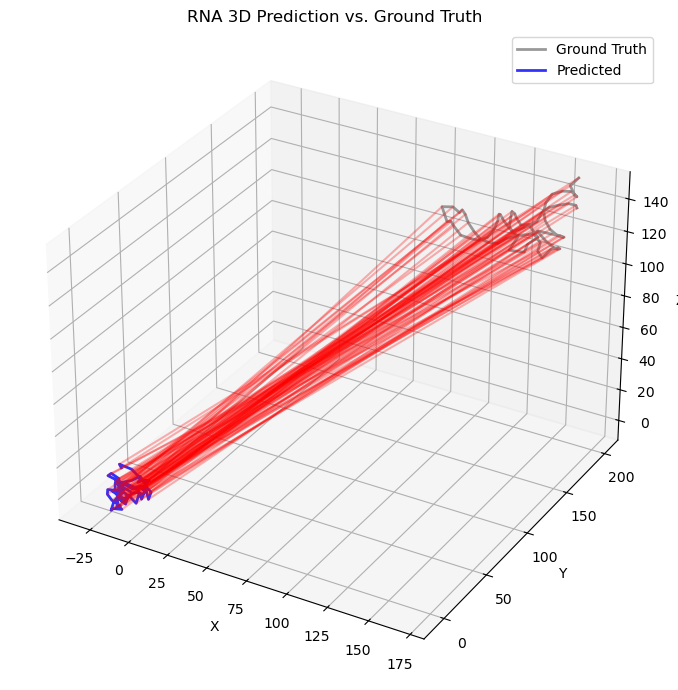

In [188]:
for batch in loader:
    pred = model(batch.x, batch.edge_index)
    plot_pred_vs_true(pred, batch.y)
    break


The training data shows a consistent decrease in loss over 20 epochs, indicating that the model is learning to reduce prediction errors. However, the TM-score remains very low throughout training (ranging from 0.0021 to 0.0037), suggesting that while the model is minimizing pairwise distance errors, it is failing to capture biologically meaningful 3D structural patterns.

To address this, fine-tuning the model architecture could be critical. For instance, the current feature set may lack global structural context. Incorporating MSA-based features, such as conservation scores or co-evolutionary couplings, could provide evolutionary signals that help the model identify likely long-range interactions and base-pairing patterns. These features, commonly used in protein and RNA structure prediction, would allow the model to go beyond purely sequence-based learning and tap into deeper structural constraints conserved across homologs.

Another promising direction is the use of contextual embeddings from pretrained RNA or protein language models (such as RiboBERT (no or ESM). These models learn deep, position-aware representations of nucleotides by training on massive sequence databases and can encode subtle dependencies between residues, even across long distances. By integrating these embeddings as node features, the GNN could gain a richer, learned representation of sequence context that better informs 3D folding.

Additionally, the model may be limited by the size and diversity of the training dataset. RNA structure prediction is inherently complex, and small datasets can lead to overfitting or poor generalization. Increasing the training data—both in number and structural diversity—would expose the model to a broader range of folding patterns and improve its ability to learn generalized structural rules.

In summary, while the model shows early signs of convergence in loss, the low TM-scores highlight the importance of fine-tuning, integrating MSA- and embedding-based structural signals, and expanding the training dataset to enable meaningful 3D structure prediction.